In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
workdir_path = '/content/drive/My Drive/TCCBI'  # Inserir o local da pasta onde estão os arquivos de entrada (treino e teste)
os.chdir(workdir_path)

In [ ]:
!ls

best_CO.h5  best_SE.h5	model_NE			     TCC.ipynb
best.h5     best_S.h5	model_S
best_NE.h5  model_CO	model_SE
best_N.h5   model_N	producao-biodiesel-m3-2005-2020.csv


#Bibiotecas

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error
from tensorflow import keras

#Tratamento Inicial

##Biodiesel

In [ ]:
diesel = pd.read_csv("producao-biodiesel-m3-2005-2020.csv",header=0, sep=";",decimal=",")
diesel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 19 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PRODUTO   1504 non-null   object 
 1   ANO       1504 non-null   int64  
 2   REGIÃO    1504 non-null   object 
 3   ESTADO    1504 non-null   object 
 4   PRODUTOR  1504 non-null   object 
 5   UNIDADE   1504 non-null   object 
 6   JAN       1500 non-null   float64
 7   FEV       1503 non-null   float64
 8   MAR       1495 non-null   float64
 9   ABR       1501 non-null   float64
 10  MAI       1496 non-null   float64
 11  JUN       1500 non-null   float64
 12  JUL       1500 non-null   float64
 13  AGO       1500 non-null   float64
 14  SET       1492 non-null   float64
 15  OUT       1492 non-null   float64
 16  NOV       1490 non-null   float64
 17  DEZ       1480 non-null   float64
 18  TOTAL     1504 non-null   float64
dtypes: float64(13), int64(1), object(5)
memory usage: 223.4+ KB


In [ ]:
diesel=diesel[['ANO','REGIÃO','JAN','FEV','MAR','ABR','MAI','JUN','JUL','AGO','SET','OUT','NOV','DEZ']]
diesel.head()

,ANO,REGIÃO,JAN,FEV,MAR,ABR,MAI,JUN,JUL,AGO,SET,OUT,NOV,DEZ
0,2005,REGIÃO SUDESTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2005,REGIÃO CENTRO-OESTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2005,REGIÃO SUL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2005,REGIÃO CENTRO-OESTE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2005,REGIÃO NORTE,0.0,0.0,0.0,13.1,14.0,21.6,0.0,25.9,0.0,20.2,241.3,174.3


In [ ]:
diesel.columns=['ANO','REGIÃO','JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
diesel

,ANO,REGIÃO,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC
0,2005,REGIÃO SUDESTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,2005,REGIÃO CENTRO-OESTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,2005,REGIÃO SUL,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,2005,REGIÃO CENTRO-OESTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,2005,REGIÃO NORTE,0.000,0.000,0.000,13.100,14.000,21.600,0.000,25.900,0.000,20.200,241.300,174.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1499,2020,REGIÃO CENTRO-OESTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1500,2020,REGIÃO SUL,16690.013,11245.912,15901.539,12363.786,15567.596,16473.021,15188.528,18610.853,17337.221,16537.482,14980.916,10952.032
1501,2020,REGIÃO CENTRO-OESTE,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1502,2020,REGIÃO NORDESTE,23350.297,22350.119,22557.038,15941.845,21077.169,23774.881,24689.269,24593.034,23120.663,23483.799,18458.451,18477.366


Transformação das colunas em linhas -> Função Melt do pandas:

In [ ]:
teste_novo=pd.melt(diesel,id_vars=['ANO','REGIÃO'], var_name='Mês',value_name='Valor')
teste_novo.head()

,ANO,REGIÃO,Mês,Valor
0,2005,REGIÃO SUDESTE,JAN,0.0
1,2005,REGIÃO CENTRO-OESTE,JAN,0.0
2,2005,REGIÃO SUL,JAN,0.0
3,2005,REGIÃO CENTRO-OESTE,JAN,0.0
4,2005,REGIÃO NORTE,JAN,0.0


União mês-ano:

In [ ]:
teste_novo["Data"]=teste_novo.apply(lambda x: str(x["ANO"])+"-"+x["Mês"],axis=1)


In [ ]:
teste_novo["Data"]=teste_novo.Data.astype(str)

In [ ]:
teste_novo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18048 entries, 0 to 18047
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ANO     18048 non-null  int64  
 1   REGIÃO  18048 non-null  object 
 2   Mês     18048 non-null  object 
 3   Valor   17949 non-null  float64
 4   Data    18048 non-null  object 
dtypes: float64(1), int64(1), object(3)
memory usage: 705.1+ KB


Trasnformar Mes-Ano em data com o strptime:

In [ ]:
teste_novo["Data"]=teste_novo.apply(lambda x: datetime.strptime(str(x["Data"]),"%Y-%b"),axis=1)

Pegar o Mês da data em formato de número

In [ ]:
teste_novo['MES']=pd.DatetimeIndex(teste_novo['Data']).month

Ordenar o dataframe de maneira decrescente de acordo com a data:

In [ ]:
teste_novo=teste_novo.sort_values(by=["Data"],ascending=False)

Separar o dataframe por regiões do Brasil:

In [ ]:
SE=teste_novo.loc[(teste_novo["REGIÃO"]=="REGIÃO SUDESTE")]
N=teste_novo.loc[(teste_novo["REGIÃO"]=="REGIÃO NORTE")]
NE=teste_novo.loc[(teste_novo["REGIÃO"]=="REGIÃO NORDESTE")]
S=teste_novo.loc[(teste_novo["REGIÃO"]=="REGIÃO SUL")]
CO=teste_novo.loc[(teste_novo["REGIÃO"]=="REGIÃO CENTRO-OESTE")]

Somatório mensal da produção de óleo a cada ano:

In [ ]:
NE_df=NE.groupby(by=['ANO','Mês'],sort=True, as_index=False).sum()
N_df=N.groupby(by=['ANO','Mês'],sort=True, as_index=False).sum()
SE_df=SE.groupby(by=['ANO','Mês'],sort=True, as_index=False).sum()
S_df=S.groupby(by=['ANO','Mês'],sort=True, as_index=False).sum()
CO_df=CO.groupby(by=['ANO','Mês'],sort=True, as_index=False).sum()
NE_biodiesel= NE_df["Valor"].values
N_biodiesel= N_df["Valor"].values
CO_biodiesel= CO_df["Valor"].values
SE_biodiesel= SE_df["Valor"].values
S_biodiesel= S_df["Valor"].values






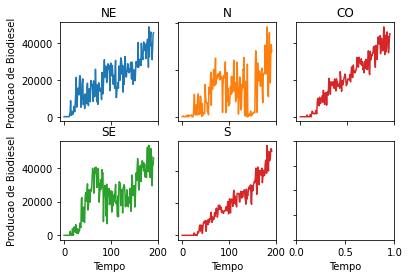

In [ ]:
fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(NE_biodiesel)
axs[0, 0].set_title('NE')
axs[0, 1].plot(N_biodiesel, 'tab:orange')
axs[0, 1].set_title('N')
axs[1, 0].plot(SE_biodiesel, 'tab:green')
axs[1, 0].set_title('SE')
axs[1, 1].plot(S_biodiesel, 'tab:red')
axs[1, 1].set_title('S')
axs[0, 2].plot(CO_biodiesel, 'tab:red')
axs[0, 2].set_title('CO')

for ax in axs.flat:
    ax.set(xlabel='Tempo', ylabel='Producao de Biodiesel')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
train_NE, test_NE = train_test_split(NE_biodiesel, test_size=0.33, shuffle=False)
train_N, test_N = train_test_split(N_biodiesel, test_size=0.33, shuffle=False)
train_CO, test_CO = train_test_split(CO_biodiesel, test_size=0.33, shuffle=False)
train_SE, test_SE = train_test_split(SE_biodiesel, test_size=0.33, shuffle=False)
train_S, test_S = train_test_split(S_biodiesel, test_size=0.33, shuffle=False)

train_NE.shape

(128,)

In [ ]:
# look_back=2

# train_size = int(len(CO_df) * 0.67)
# test_size = len(CO_df) - train_size
# train_NE, test_NE = NE_biodiesel[0:train_size], NE_biodiesel[train_size-look_back-1:len(CO_df)]
# train_N, test_N = N_biodiesel[0:train_size], N_biodiesel[train_size-look_back-1:len(CO_df)]
# train_CO, test_CO = CO_biodiesel[0:train_size], CO_biodiesel[train_size-look_back-1:len(CO_df)]
# train_SE, test_SE = SE_biodiesel[0:train_size], SE_biodiesel[train_size-look_back-1:len(CO_df)]
# train_S, test_S = S_biodiesel[0:train_size], S_biodiesel[train_size-look_back-1:len(CO_df)]
# train_NE.shape

In [ ]:
# # Recebe uma série e converte em uma matriz com séries deslocadas.
# def create_dataset(dataset, look_back=1,std=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back):
#         a = dataset[i:(i+look_back)]-dataset[i]
#         # a /= std
#         dataX.append(a)
#         dataY.append(dataset[i + look_back]-dataset[i + look_back-1])
#     return np.array(dataX), np.array(dataY)

# # reshape into X=t and Y=t+1
# std = train_NE[:].std()
# trainX, trainY = create_dataset(train_NE, look_back,std)
# testX, testY = create_dataset(test_NE, look_back)
# # shape is [samples, time steps, features]

# trainX = trainX.reshape(-1, look_back, 1)
# testX = testX.reshape(-1, look_back, 1)
# trainY = trainY / 30
# testY = testY / 30

# trainX.shape, testX.shape

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
NE_biodiesel_train_scaled = sc.fit_transform(train_NE.reshape(-1,1))
N_biodiesel_train_scaled = sc.fit_transform(train_N.reshape(-1,1))
CO_biodiesel_train_scaled = sc.fit_transform(train_CO.reshape(-1,1))
SE_biodiesel_train_scaled = sc.fit_transform(train_SE.reshape(-1,1))
S_biodiesel_train_scaled = sc.fit_transform(train_S.reshape(-1,1))
# NE_biodiesel_scaled= pd.DataFrame(NE_biodiesel_scaled)
NE_biodiesel_train_scaled.shape

(128, 1)

In [ ]:
# window = 2
# trainSize = len(train_NE)
# X_train_NE = []
# y_train_NE = []
# X_train_N = []
# y_train_N = []
# X_train_CO = []
# y_train_CO = []
# X_train_SE = []
# y_train_SE = []
# X_train_S = []
# y_train_S = []
# for i in range(window, trainSize):
#     X_train_NE.append(NE_biodiesel_train_scaled[i-window:i])
#     y_train_NE.append(NE_biodiesel_train_scaled[i])
#     X_train_N.append(N_biodiesel_train_scaled[i-window:i])
#     y_train_N.append(N_biodiesel_train_scaled[i])
#     X_train_CO.append(CO_biodiesel_train_scaled[i-window:i])
#     y_train_CO.append(CO_biodiesel_train_scaled[i])
#     X_train_SE.append(SE_biodiesel_train_scaled[i-window:i])
#     y_train_SE.append(SE_biodiesel_train_scaled[i])
#     X_train_S.append(S_biodiesel_train_scaled[i-window:i])
#     y_train_S.append(S_biodiesel_train_scaled[i])
# X_train_NE, y_train_NE = np.array(X_train_NE), np.array(y_train_NE)
# X_train_N, y_train_N = np.array(X_train_N), np.array(y_train_N)
# X_train_CO, y_train_CO = np.array(X_train_CO), np.array(y_train_CO)
# X_train_SE, y_train_SE = np.array(X_train_SE), np.array(y_train_SE)
# X_train_S, y_train_S = np.array(X_train_S), np.array(y_train_S)
# X_train_NE.shape


In [ ]:
window = 4

batch_size = len(NE_biodiesel_train_scaled)

n_features = 1

generator_NE = TimeseriesGenerator(NE_biodiesel_train_scaled, NE_biodiesel_train_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_N = TimeseriesGenerator(N_biodiesel_train_scaled, N_biodiesel_train_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_CO = TimeseriesGenerator(CO_biodiesel_train_scaled, CO_biodiesel_train_scaled, length=window, batch_size=batch_size,shuffle=False)
generator_SE = TimeseriesGenerator(SE_biodiesel_train_scaled, SE_biodiesel_train_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_S = TimeseriesGenerator(S_biodiesel_train_scaled, S_biodiesel_train_scaled,  length=window, batch_size=batch_size,shuffle=False)
for i in range(len(generator_NE)):
      X_train_NE,y_train_NE=generator_NE[i]
      X_train_N,y_train_N=generator_N[i]
      X_train_CO,y_train_CO=generator_CO[i]
      X_train_SE,y_train_SE=generator_SE[i]
      X_train_S,y_train_S=generator_S[i]

X_train_NE,y_train_NE

(array([[[0.00000000e+00],
         [6.24569028e-05],
         [3.46228483e-03],
         [0.00000000e+00]],
 
        [[6.24569028e-05],
         [3.46228483e-03],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[3.46228483e-03],
         [0.00000000e+00],
         [0.00000000e+00],
         [4.68426771e-05]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [4.68426771e-05],
         [0.00000000e+00]],
 
        [[0.00000000e+00],
         [4.68426771e-05],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[4.68426771e-05],
         [0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [0.00000000e+00],
         [1.24913806e-03]],
 
        [[0.00000000e+00],
         [0.00000000e+00],
         [1.24913806e-03],
         [0.00000000e+00]],
 
        [[0.00000000e+00],
         [1.24913806e-03],
         [0.00000000e+00],
         [6.24569028e-05]],
 
 

In [ ]:
# from tensorflow import keras

# model_NE = keras.models.load_model("model_NE")
# model_N = keras.models.load_model("model_N")
# model_CO = keras.models.load_model("model_CO")
# model_SE = keras.models.load_model("model_SE")
# model_S = keras.models.load_model("model_S")

In [ ]:
# Initicializar a RNN
model_NE = Sequential()
model_N = Sequential()
model_CO = Sequential()
model_SE = Sequential()
model_S = Sequential()

 
# Adicionar LSTM Bidirecional 
model_NE.add((Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_NE.shape[1],1))))
model_NE.add((Dropout(0.1)))
model_N.add((Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_NE.shape[1],1))))
model_N.add((Dropout(0.1)))
model_CO.add((Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_NE.shape[1],1))))
model_CO.add((Dropout(0.1)))
model_SE.add((Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_NE.shape[1],1))))
model_SE.add((Dropout(0.1)))
model_S.add((Bidirectional(LSTM(100, return_sequences=True), input_shape=(X_train_NE.shape[1],1))))
model_S.add((Dropout(0.1)))
 
# Adicionar a segunda camada LSTM e Dropout
model_NE.add((Bidirectional(LSTM(units = 80, return_sequences = True))))
model_NE.add(Dropout(0.1))
model_N.add((Bidirectional(LSTM(units = 80, return_sequences = True))))
model_N.add(Dropout(0.1))
model_CO.add((Bidirectional(LSTM(units = 80, return_sequences = True))))
model_CO.add(Dropout(0.1))
model_SE.add((Bidirectional(LSTM(units = 80, return_sequences = True))))
model_SE.add(Dropout(0.1))
model_S.add((Bidirectional(LSTM(units = 80, return_sequences = True))))
model_S.add(Dropout(0.1))
 
# Adicionar a terceira camada LSTM e Dropout
model_NE.add((Bidirectional(LSTM(units = 50))))
model_NE.add(Dropout(0.1))
model_N.add((Bidirectional(LSTM(units = 50))))
model_N.add(Dropout(0.1))
model_CO.add((Bidirectional(LSTM(units = 50))))
model_CO.add(Dropout(0.1))
model_SE.add((Bidirectional(LSTM(units = 50))))
model_SE.add(Dropout(0.1))
model_S.add((Bidirectional(LSTM(units = 50))))
model_S.add(Dropout(0.1))
 
# camada de saída
model_NE.add(Dense(units = 1))
model_N.add(Dense(units = 1))
model_CO.add(Dense(units = 1))
model_SE.add(Dense(units = 1))
model_S.add(Dense(units = 1))
 
# Compilar a rede
model_NE.compile(optimizer = 'SGD', loss = "mean_squared_error")
model_N.compile(optimizer = 'SGD', loss = "mean_squared_error")
model_CO.compile(optimizer = 'SGD', loss = "mean_squared_error")
model_SE.compile(optimizer = 'SGD', loss = "mean_squared_error")
model_S.compile(optimizer = 'SGD', loss = "mean_squared_error")

# Visualizar a rede
model_NE.summary()
model_N.summary()
model_CO.summary()
model_SE.summary()
model_S.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_15 (Bidirectio (None, 4, 200)            81600     
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 200)            0         
_________________________________________________________________
bidirectional_20 (Bidirectio (None, 4, 160)            179840    
_________________________________________________________________
dropout_20 (Dropout)         (None, 4, 160)            0         
_________________________________________________________________
bidirectional_25 (Bidirectio (None, 100)               84400     
_________________________________________________________________
dropout_25 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:

# history_NE=model_NE.load_weights('best_NE.h5')
# history_N=model_N.load_weights('best_N.h5')
# history_CO=model_CO.load_weights('best_CO.h5')
# history_SE=model_SE.load_weights('best_SE.h5')
# history_S=model_S.load_weights('best_SE.h5')
# history_NE

In [ ]:
es = EarlyStopping(patience=100)
rlr = ReduceLROnPlateau(patience=100)
mc_NE = ModelCheckpoint(filepath='best_NE.h5', save_best_only=True,save_weights_only=False)
mc_N = ModelCheckpoint(filepath='best_N.h5', save_best_only=True,save_weights_only=False)
mc_CO = ModelCheckpoint(filepath='best_CO.h5', save_best_only=True,save_weights_only=False)
mc_SE = ModelCheckpoint(filepath='best_SE.h5', save_best_only=True,save_weights_only=False)
mc_S = ModelCheckpoint(filepath='best_S.h5', save_best_only=True,save_weights_only=False)


history_NE=model_NE.fit(X_train_NE, y_train_NE, epochs = 1000, batch_size = 8,validation_split=0.2,callbacks=[es, mc_NE, rlr])
history_N=model_N.fit(X_train_N, y_train_N, epochs = 1000, batch_size = 8,validation_split=0.2,callbacks=[es, mc_N, rlr])
history_CO=model_CO.fit(X_train_CO, y_train_CO, epochs = 1000, batch_size = 8,validation_split=0.2,callbacks=[es, mc_CO, rlr])
history_SE=model_SE.fit(X_train_SE, y_train_SE, epochs = 1000, batch_size = 8,validation_split=0.2,callbacks=[es, mc_SE, rlr])
history_S=model_S.fit(X_train_S, y_train_S, epochs = 1000, batch_size = 8,validation_split=0.2,callbacks=[es, mc_S, rlr])

Epoch 1/1000
13/13 [==============================] - 10s 191ms/step - loss: 0.2294 - val_loss: 0.3013
Epoch 2/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.1089 - val_loss: 0.2044
Epoch 3/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0738 - val_loss: 0.1622
Epoch 4/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0665 - val_loss: 0.1401
Epoch 5/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0798 - val_loss: 0.1305
Epoch 6/1000
13/13 [==============================] - 0s 13ms/step - loss: 0.0714 - val_loss: 0.1226
Epoch 7/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0597 - val_loss: 0.1154
Epoch 8/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0731 - val_loss: 0.1126
Epoch 9/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0665 - val_loss: 0.1116
Epoch 10/1000
13/13 [==============================] - 0s 12ms/step - loss: 0.0730 - val_

In [ ]:
# history_NE.model.save("model_NE")
# history_N.model.save("model_N")
# history_CO.model.save("model_CO")
# history_SE.model.save("model_SE")
# history_S.model.save("model_S")

INFO:tensorflow:Assets written to: model_NE/assets


INFO:tensorflow:Assets written to: model_NE/assets


INFO:tensorflow:Assets written to: model_N/assets


INFO:tensorflow:Assets written to: model_N/assets


INFO:tensorflow:Assets written to: model_CO/assets


INFO:tensorflow:Assets written to: model_CO/assets


INFO:tensorflow:Assets written to: model_SE/assets


INFO:tensorflow:Assets written to: model_SE/assets


INFO:tensorflow:Assets written to: model_S/assets


INFO:tensorflow:Assets written to: model_S/assets


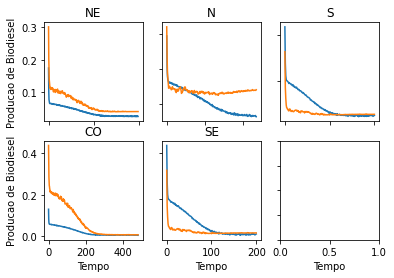

In [ ]:
# plt.plot(history_SE.history['loss'], label='treino')
# plt.plot(history_SE.history['val_loss'], label='validacao')
# plt.legend();

fig, axs = plt.subplots(2, 3)
axs[0, 0].plot(history_NE.history['loss'], label='treino')
axs[0, 0].plot(history_NE.history['val_loss'], label='validacao')
axs[0, 0].set_title('NE')
axs[0, 1].plot(history_N.history['loss'], label='treino')
axs[0, 1].plot(history_N.history['val_loss'], label='validacao')
axs[0, 1].set_title('N')
axs[1, 0].plot(history_CO.history['loss'], label='treino')
axs[1, 0].plot(history_CO.history['val_loss'], label='validacao')
axs[1, 0].set_title('CO')
axs[1, 1].plot(history_SE.history['loss'], label='treino')
axs[1, 1].plot(history_SE.history['val_loss'], label='validacao')
axs[1, 1].set_title('SE')
axs[0, 2].plot(history_SE.history['loss'], label='treino')
axs[0, 2].plot(history_SE.history['val_loss'], label='validacao')
axs[0, 2].set_title('S')

for ax in axs.flat:
    ax.set(xlabel='Tempo', ylabel='Producao de Biodiesel')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

In [ ]:
testLength = len(test_NE)
# inputs = dataset_total[len(dataset_total) - testLength - window:].values
NE_biodiesel_test_scaled = sc.transform(test_NE.reshape(-1,1))
N_biodiesel_test_scaled = sc.transform(test_N.reshape(-1,1))
CO_biodiesel_test_scaled = sc.transform(test_CO.reshape(-1,1))
SE_biodiesel_test_scaled = sc.transform(test_SE.reshape(-1,1))
S_biodiesel_test_scaled = sc.transform(test_S.reshape(-1,1))



In [ ]:
window = 4

batch_size = len(NE_biodiesel_test_scaled)

n_features = 1

generator_NE_test = TimeseriesGenerator(NE_biodiesel_test_scaled, NE_biodiesel_test_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_N_test = TimeseriesGenerator(N_biodiesel_test_scaled, N_biodiesel_test_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_CO_test = TimeseriesGenerator(CO_biodiesel_test_scaled, CO_biodiesel_test_scaled, length=window, batch_size=batch_size,shuffle=False)
generator_SE_test = TimeseriesGenerator(SE_biodiesel_test_scaled, SE_biodiesel_test_scaled,  length=window, batch_size=batch_size,shuffle=False)
generator_S_test = TimeseriesGenerator(S_biodiesel_test_scaled, S_biodiesel_test_scaled,  length=window, batch_size=batch_size,shuffle=False)
for i in range(len(generator_NE)):
      X_test_NE,y_test_NE=generator_NE_test[i]
      X_test_N,y_test_N=generator_N[i]
      X_test_CO,y_test_CO=generator_CO[i]
      X_test_SE,y_test_SE=generator_SE[i]
      X_test_S,y_test_S=generator_S[i]

X_test_NE,y_test_NE

(array([[[0.12495592],
         [0.19233096],
         [0.23235013],
         [0.21160437]],
 
        [[0.19233096],
         [0.23235013],
         [0.21160437],
         [0.15469073]],
 
        [[0.23235013],
         [0.21160437],
         [0.15469073],
         [0.15324113]],
 
        [[0.21160437],
         [0.15469073],
         [0.15324113],
         [0.17541989]],
 
        [[0.15469073],
         [0.15324113],
         [0.17541989],
         [0.17613067]],
 
        [[0.15324113],
         [0.17541989],
         [0.17613067],
         [0.20445667]],
 
        [[0.17541989],
         [0.17613067],
         [0.20445667],
         [0.18504305]],
 
        [[0.17613067],
         [0.20445667],
         [0.18504305],
         [0.17949542]],
 
        [[0.20445667],
         [0.18504305],
         [0.17949542],
         [0.16949419]],
 
        [[0.18504305],
         [0.17949542],
         [0.16949419],
         [0.1859939 ]],
 
        [[0.17949542],
         [0.16949419],
    

In [ ]:
predicted_NE=model_NE.predict(X_test_NE)
predicted_N=model_N.predict(X_test_N)
predicted_CO=model_CO.predict(X_test_CO)
predicted_SE=model_SE.predict(X_test_SE)
predicted_S=model_S.predict(X_test_S)

In [ ]:
train_predicted_NE=model_NE.predict(X_train_NE)
train_predicted_N=model_N.predict(X_train_N)
train_predicted_CO=model_CO.predict(X_train_CO)
train_predicted_SE=model_SE.predict(X_train_SE)
train_predicted_S=model_S.predict(X_train_S)

In [ ]:
# import math
# from sklearn.metrics import mean_squared_error

trainScore = math.sqrt(mean_squared_error(train_predicted_NE, y_train_NE))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(predicted_NE, y_test_NE))
print('Test Score: %.2f RMSE' % (testScore))

trainScore = math.sqrt(mean_squared_error(train_predicted_N, y_train_N))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(predicted_N, y_test_N))
print('Test Score: %.2f RMSE' % (testScore))


trainScore = math.sqrt(mean_squared_error(train_predicted_CO, y_train_CO))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(predicted_CO, y_test_CO))
print('Test Score: %.2f RMSE' % (testScore))


trainScore = math.sqrt(mean_squared_error(train_predicted_SE, y_train_SE))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(predicted_SE, y_test_SE))
print('Test Score: %.2f RMSE' % (testScore))


trainScore = math.sqrt(mean_squared_error(train_predicted_S, y_train_S))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(predicted_S, y_test_S))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.17 RMSE
Test Score: 0.05 RMSE
Train Score: 0.20 RMSE
Test Score: 0.20 RMSE
Train Score: 0.08 RMSE
Test Score: 0.08 RMSE
Train Score: 0.16 RMSE
Test Score: 0.16 RMSE
Train Score: 0.08 RMSE
Test Score: 0.08 RMSE


In [ ]:
original_test_NE=np.append(X_test_NE[0],y_test_NE)
original_test_N=np.append(X_test_N[0],y_test_N)
original_test_CO=np.append(X_test_CO[0],y_test_CO)
original_test_SE=np.append(X_test_SE[0],y_test_SE)
original_test_S=np.append(X_test_S[0],y_test_S)

predicted_test_NE=np.append(X_test_NE[0],predicted_NE)
predicted_test_N=np.append(X_test_N[0],predicted_N)
predicted_test_CO=np.append(X_test_CO[0],predicted_CO)
predicted_test_SE=np.append(X_test_SE[0],predicted_SE)
predicted_test_S=np.append(X_test_S[0],predicted_S)

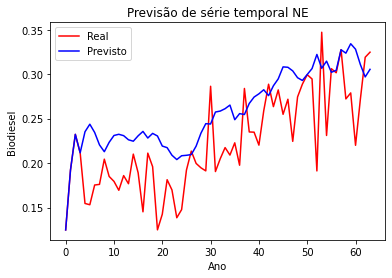

In [ ]:
plt.plot( original_test_NE, color = 'red', label = 'Real')
plt.plot( predicted_test_NE, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal NE')
plt.xlabel('Ano')
plt.ylabel('Biodiesel')
plt.legend()
plt.show()

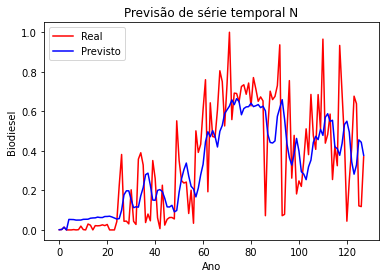

In [ ]:
plt.plot( original_test_N, color = 'red', label = 'Real')
plt.plot( predicted_test_N, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal N')
plt.xlabel('Ano')
# plt.xlim(2000,2019)
# plt.xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,  2016,  2018])
plt.ylabel('Biodiesel')
plt.legend()
plt.show()

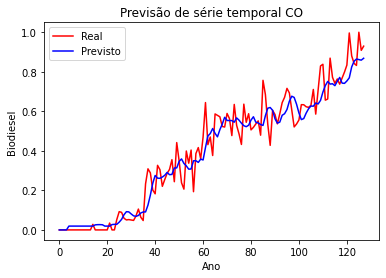

In [ ]:
plt.plot( original_test_CO, color = 'red', label = 'Real')
plt.plot( predicted_test_CO, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal CO')
plt.xlabel('Ano')
# plt.xlim(2000,2019)
# plt.xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,  2016,  2018])
plt.ylabel('Biodiesel')
plt.legend()
plt.show()

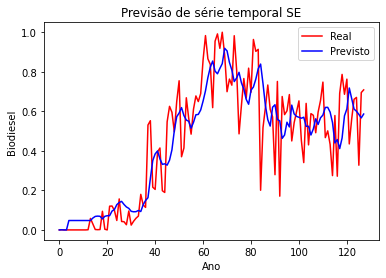

In [ ]:
plt.plot( original_test_SE, color = 'red', label = 'Real')
plt.plot( predicted_test_SE, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal SE')
plt.xlabel('Ano')
# plt.xlim(2000,2019)
# plt.xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,  2016,  2018])
plt.ylabel('Biodiesel')
plt.legend()
plt.show()

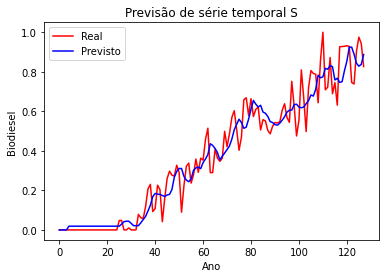

In [ ]:
plt.plot( original_test_S, color = 'red', label = 'Real')
plt.plot( predicted_test_S, color = 'blue', label = 'Previsto')
plt.title('Previsão de série temporal S')
plt.xlabel('Ano')
# plt.xlim(2000,2019)
# plt.xticks([2000, 2002, 2004, 2006, 2008, 2010, 2012, 2014,  2016,  2018])
plt.ylabel('Biodiesel')
plt.legend()
plt.show()

In [ ]:
# test_NE = []
# test_N = []
# test_CO = []
# test_SE = []
# test_S = []


# test_NE=np.append(test_NE,X_test_NE[0])
# test_N=np.append(test_N,X_test_N[0])
# test_CO=np.append(test_CO,X_test_CO[0])
# test_SE=np.append(test_SE,X_test_SE[0])
# test_S=np.append(test_S,X_test_S[0])


# for i in range(1,len(X_test_NE)):
#     test_NE=np.append(test_NE,X_test_NE[i][1])
#     test_N=np.append(test_N,X_test_N[i][1])
#     test_CO=np.append(test_CO,X_test_CO[i][1])
#     test_SE=np.append(test_SE,X_test_SE[i][1])
#     test_S=np.append(test_S,X_test_S[i][1])

# # test_NE

# predicted_NE = []
# predicted_N = []
# predicted_CO = []
# predicted_SE = []
# predicted_S = []

# predicted_NE.
# predicted_NE=np.append(predicted_NE,X_test_NE[0])
# predicted_N=np.append(predicted_N,X_test_N[0])
# predicted_CO=np.append(predicted_CO,X_test_CO[0])
# predicted_SE=np.append(predicted_SE,X_test_SE[0])
# predicted_S=np.append(predicted_S,X_test_S[0])

# for i in range(1,len(X_test_NE)):
#     predicted_NE=np.append(predicted_NE,X_test_NE[i][1])
#     predicted_N=np.append(predicted_N,X_test_N[i][1])
#     predicted_CO=np.append(predicted_CO,X_test_CO[i][1])
#     predicted_SE=np.append(predicted_SE,X_test_SE[i][1])
#     predicted_S=np.append(predicted_S,X_test_S[i][1])
    
# test_NE

##Diesel

In [ ]:
bio_20202 = pd.read_csv("ca-2020-02.csv", engine='python',sep=';',decimal=",",encoding="latin-1" )
bio_20201 = pd.read_csv("ca-2020-01.csv", engine='python',sep=';',decimal=",",encoding="latin-1" )
bio_20192 = pd.read_csv("ca-2019-02.csv", engine='python',sep=';',decimal=",",encoding="latin-1" )
bio_20191 = pd.read_csv("ca-2019-01.csv", engine='python',sep=';',decimal=",",encoding="latin-1" )


In [ ]:
bio_20202.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222637 entries, 0 to 222636
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ï»¿Regiao - Sigla  222637 non-null  object 
 1   Estado - Sigla     222637 non-null  object 
 2   Municipio          222637 non-null  object 
 3   Revenda            222637 non-null  object 
 4   CNPJ da Revenda    222637 non-null  object 
 5   Nome da Rua        222637 non-null  object 
 6   Numero Rua         222465 non-null  object 
 7   Complemento        54744 non-null   object 
 8   Bairro             221986 non-null  object 
 9   Cep                222637 non-null  object 
 10  Produto            222637 non-null  object 
 11  Data da Coleta     222637 non-null  object 
 12  Valor de Venda     222637 non-null  float64
 13  Valor de Compra    27037 non-null   float64
 14  Unidade de Medida  222637 non-null  object 
 15  Bandeira           222637 non-null  object 
dtypes:

Renomeação das colunas:

In [ ]:
bio_20202.columns=["Regiao","Estado","Municipio","Revenda","CNPJ","Rua","Numero","Complemento","Bairro","CEP","Produto","Data","Venda","Compra","Unidade","Bandeira"]
bio_20201.columns=["Regiao","Estado","Municipio","Revenda","CNPJ","Rua","Numero","Complemento","Bairro","CEP","Produto","Data","Venda","Compra","Unidade","Bandeira"]
bio_20192.columns=["Regiao","Estado","Municipio","Revenda","CNPJ","Rua","Numero","Complemento","Bairro","CEP","Produto","Data","Venda","Compra","Unidade","Bandeira"]
bio_20191.columns=["Regiao","Estado","Municipio","Revenda","CNPJ","Rua","Numero","Complemento","Bairro","CEP","Produto","Data","Venda","Compra","Unidade","Bandeira"]

In [ ]:
bio_20191.head()

,Regiao,Estado,Municipio,Revenda,CNPJ,Rua,Numero,Complemento,Bairro,CEP,Produto,Data,Venda,Compra,Unidade,Bandeira
0,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GASOLINA,03/01/2019,4.199,3.5766,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
1,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,ETANOL,03/01/2019,2.899,2.3513,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,03/01/2019,3.349,2.8841,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
3,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,GNV,03/01/2019,2.439,NaN,R$ / mÂ³,PETROBRAS DISTRIBUIDORA S.A.
4,S,RS,CANOAS,METROPOLITANO COMERCIO DE COMBUSTIVEIS LTDA,88.587.589/0001-17,AVENIDA GUILHERME SCHELL,6340,NaN,CENTRO,92310-000,GASOLINA,02/01/2019,4.399,3.8550,R$ / litro,BRANCA


Filtrar o dataframe para mostrar apenas Diesel e Diesel S10

In [ ]:
bio_20202=bio_20202.loc[(bio_20202["Produto"]=="DIESEL S10") | (bio_20202["Produto"]=="DIESEL")]
bio_20201=bio_20201.loc[(bio_20201["Produto"]=="DIESEL S10") | (bio_20201["Produto"]=="DIESEL")]
bio_20192=bio_20192.loc[(bio_20192["Produto"]=="DIESEL S10") | (bio_20192["Produto"]=="DIESEL")]
bio_20191=bio_20191.loc[(bio_20191["Produto"]=="DIESEL S10") | (bio_20191["Produto"]=="DIESEL")]


Mesclando os dataframes sem ordená-los:

In [ ]:
biodiesel=bio_20201.append(bio_20202, sort=False)
biodiesel=bio_20192.append(biodiesel, sort=False)
biodiesel=bio_20191.append(biodiesel, sort=False)
biodiesel

,Regiao,Estado,Municipio,Revenda,CNPJ,Rua,Numero,Complemento,Bairro,CEP,Produto,Data,Venda,Compra,Unidade,Bandeira
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,03/01/2019,3.349,2.8841,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
9,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,02/01/2019,3.300,NaN,R$ / litro,BRANCA
10,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,02/01/2019,3.400,NaN,R$ / litro,BRANCA
13,S,PR,PATO BRANCO,SANTOS & MERLO LTDA.,79.854.667/0001-01,RUA TOCANTINS,2535,NaN,CENTRO,85501-010,DIESEL S10,02/01/2019,3.290,NaN,R$ / litro,RODOIL
15,S,RS,PORTO ALEGRE,COMERCIAL DE COMBUSTIVEIS TK LTDA,91.438.796/0001-14,RUA EDUARDO PRADO,415,CAVALHADA,CAVALHADA,91751-000,DIESEL,02/01/2019,3.399,2.8878,R$ / litro,RAIZEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222624,SE,SP,AVARE,AUTO POSTO REDE LEMANS LTDA,36.710.410/0001-73,AVENIDA SALIM ANTONIO CURIATI,927,NaN,JARDIM BRASIL,18702-640,DIESEL S10,29/12/2020,3.499,NaN,R$ / litro,BRANCA
222625,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL S10,28/12/2020,3.869,NaN,R$ / litro,IPIRANGA
222627,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL,28/12/2020,3.799,NaN,R$ / litro,IPIRANGA
222633,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,DIESEL,29/12/2020,3.699,NaN,R$ / litro,RAIZEN


Transformação da data com o strptime:

In [ ]:
#custom_date_parser = lambda x: datetime.strptime(x["Data"],"%d/%M/%Y")
biodiesel["Data"]=biodiesel.apply(lambda x: datetime.strptime(x["Data"],"%d/%m/%Y"),axis=1)
biodiesel

,Regiao,Estado,Municipio,Revenda,CNPJ,Rua,Numero,Complemento,Bairro,CEP,Produto,Data,Venda,Compra,Unidade,Bandeira
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,2019-01-03,3.349,2.8841,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.
9,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,2019-01-02,3.300,NaN,R$ / litro,BRANCA
10,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,2019-01-02,3.400,NaN,R$ / litro,BRANCA
13,S,PR,PATO BRANCO,SANTOS & MERLO LTDA.,79.854.667/0001-01,RUA TOCANTINS,2535,NaN,CENTRO,85501-010,DIESEL S10,2019-01-02,3.290,NaN,R$ / litro,RODOIL
15,S,RS,PORTO ALEGRE,COMERCIAL DE COMBUSTIVEIS TK LTDA,91.438.796/0001-14,RUA EDUARDO PRADO,415,CAVALHADA,CAVALHADA,91751-000,DIESEL,2019-01-02,3.399,2.8878,R$ / litro,RAIZEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222624,SE,SP,AVARE,AUTO POSTO REDE LEMANS LTDA,36.710.410/0001-73,AVENIDA SALIM ANTONIO CURIATI,927,NaN,JARDIM BRASIL,18702-640,DIESEL S10,2020-12-29,3.499,NaN,R$ / litro,BRANCA
222625,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL S10,2020-12-28,3.869,NaN,R$ / litro,IPIRANGA
222627,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL,2020-12-28,3.799,NaN,R$ / litro,IPIRANGA
222633,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,DIESEL,2020-12-29,3.699,NaN,R$ / litro,RAIZEN


Extração do dia, mês e ano de cada data:

In [ ]:
biodiesel['DIA']=pd.DatetimeIndex(biodiesel['Data']).day
biodiesel['MES']=pd.DatetimeIndex(biodiesel['Data']).month
biodiesel['ANO']=pd.DatetimeIndex(biodiesel['Data']).year
biodiesel


,Regiao,Estado,Municipio,Revenda,CNPJ,Rua,Numero,Complemento,Bairro,CEP,Produto,Data,Venda,Compra,Unidade,Bandeira,DIA,MES,ANO
2,SE,SP,GUARULHOS,AUTO POSTO SAKAMOTO LTDA,49.051.667/0001-02,RODOVIA PRESIDENTE DUTRA,S/N,"KM 210,5-SENT SP/RJ",BONSUCESSO,07178-580,DIESEL S10,2019-01-03,3.349,2.8841,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,3,1,2019
9,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL,2019-01-02,3.300,NaN,R$ / litro,BRANCA,2,1,2019
10,NE,BA,ITABUNA,LOPES LEMOS COMERCIO DE COMBUSTIVEIS LTDA,00.231.792/0001-05,RODOVIA BR 101,SN,KM 503 5,MANOEL LEAO,45601-402,DIESEL S10,2019-01-02,3.400,NaN,R$ / litro,BRANCA,2,1,2019
13,S,PR,PATO BRANCO,SANTOS & MERLO LTDA.,79.854.667/0001-01,RUA TOCANTINS,2535,NaN,CENTRO,85501-010,DIESEL S10,2019-01-02,3.290,NaN,R$ / litro,RODOIL,2,1,2019
15,S,RS,PORTO ALEGRE,COMERCIAL DE COMBUSTIVEIS TK LTDA,91.438.796/0001-14,RUA EDUARDO PRADO,415,CAVALHADA,CAVALHADA,91751-000,DIESEL,2019-01-02,3.399,2.8878,R$ / litro,RAIZEN,2,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222624,SE,SP,AVARE,AUTO POSTO REDE LEMANS LTDA,36.710.410/0001-73,AVENIDA SALIM ANTONIO CURIATI,927,NaN,JARDIM BRASIL,18702-640,DIESEL S10,2020-12-29,3.499,NaN,R$ / litro,BRANCA,29,12,2020
222625,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL S10,2020-12-28,3.869,NaN,R$ / litro,IPIRANGA,28,12,2020
222627,SE,SP,ARACATUBA,POSTO UNI ICARAY LTDA,37.715.385/0001-83,AVENIDA JOAQUIM POMPEU DE TOLEDO,1631,NaN,ICARAY,16020-405,DIESEL,2020-12-28,3.799,NaN,R$ / litro,IPIRANGA,28,12,2020
222633,SE,RJ,RIO DE JANEIRO,AUTO POSTO REDE PARCEIRO ANIL LTDA,30.865.289/0001-72,AVENIDA TENENTE CORONEL MUNIZ DE ARAGAO,0,LOT ESCOLA PAL 30470,ANIL,22765-006,DIESEL,2020-12-29,3.699,NaN,R$ / litro,RAIZEN,29,12,2020


Ordenar o dataframe de maneira decrescente por data:

In [ ]:
biodiesel=biodiesel.sort_values(by=["Data"],ascending=False)
biodiesel

,Regiao,Estado,Municipio,Revenda,CNPJ,Rua,Numero,Complemento,Bairro,CEP,Produto,Data,Venda,Compra,Unidade,Bandeira,DIA,MES,ANO
218599,SE,SP,CAMPINAS,ALMEIDA & L. OLIVEIRA COMÃRCIO DE COMBUSTÃVE...,45.994.357/0001-70,AVENIDA JOHN BOYD DUNLOP,460,NaN,CHACARA REPUBLICA,13100-000,DIESEL S10,2020-12-31,3.577,NaN,R$ / litro,RAIZEN,31,12,2020
218477,SE,SP,CAMPINAS,AUTO POSTO M.A.M.P. LTDA - ME,08.730.324/0001-97,AVENIDA SENADOR SARAIVA,957,NaN,CENTRO,13013-061,DIESEL S10,2020-12-31,3.399,NaN,R$ / litro,BRANCA,31,12,2020
218608,SE,SP,CAMPINAS,AUTO POSTO BABALU LTDA,44.594.687/0001-06,AVENIDA ANDRADE NEVES,1843,NaN,CHAPADÃO,13100-000,DIESEL,2020-12-31,3.297,NaN,R$ / litro,BRANCA,31,12,2020
222176,S,RS,GUAIBA,ABASTECEDORA DE COMBUSTIVEIS RIOXEL LTDA,03.358.858/0017-88,AVENIDA NESTOR DE MOURA JARDIM,540,NaN,CORONEL NASSUCA,92701-230,DIESEL S10,2020-12-31,3.609,NaN,R$ / litro,IPIRANGA,31,12,2020
222180,S,RS,GUAIBA,ABASTECEDORA DE COMBUSTIVEIS RIOXEL LTDA,03.358.858/0017-88,AVENIDA NESTOR DE MOURA JARDIM,540,NaN,CORONEL NASSUCA,92701-230,DIESEL,2020-12-31,3.509,NaN,R$ / litro,IPIRANGA,31,12,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9070,NE,MA,IMPERATRIZ,AUTO POSTO DT LTDA,05.066.395/0001-49,RUA LEONCIO PIRES DOURADO,1463,NaN,BACURI,65910-140,DIESEL S10,2019-01-02,3.759,NaN,R$ / litro,ALESAT,2,1,2019
9072,NE,MA,IMPERATRIZ,POSTO REGINA DE PETROLEO LTDA,23.432.842/0001-18,RODOVIA BR 010 KM 1352,SN,NaN,COCO GRANDE,65903-390,DIESEL,2019-01-02,3.469,NaN,R$ / litro,SABBÃ,2,1,2019
9073,NE,MA,IMPERATRIZ,POSTO REGINA DE PETROLEO LTDA,23.432.842/0001-18,RODOVIA BR 010 KM 1352,SN,NaN,COCO GRANDE,65903-390,DIESEL S10,2019-01-02,3.529,NaN,R$ / litro,SABBÃ,2,1,2019
9076,NE,MA,IMPERATRIZ,JOAO MARTINS HERENIO,06.411.946/0001-27,RODOVIA BR 010,S/N,KM 608,RODOVIÃRIA PARQUE,65901-000,DIESEL S10,2019-01-02,3.699,NaN,R$ / litro,PETROBRAS DISTRIBUIDORA S.A.,2,1,2019


In [ ]:
biodiesel=biodiesel[['ANO','Regiao','MES','Venda']]
biodiesel

,ANO,Regiao,MES,Venda
218599,2020,SE,12,3.577
218477,2020,SE,12,3.399
218608,2020,SE,12,3.297
222176,2020,S,12,3.609
222180,2020,S,12,3.509
...,...,...,...,...
9070,2019,NE,1,3.759
9072,2019,NE,1,3.469
9073,2019,NE,1,3.529
9076,2019,NE,1,3.699


Separar o dataframe por região do Brasil:

In [ ]:
SE=biodiesel.loc[(biodiesel["Regiao"])=="SE"]
S=biodiesel.loc[(biodiesel["Regiao"])=="S"]
NE=biodiesel.loc[(biodiesel["Regiao"])=="NE"]
N=biodiesel.loc[(biodiesel["Regiao"])=="N"]
CO=biodiesel.loc[(biodiesel["Regiao"])=="CO"]


,ANO,Regiao,MES,Venda
218599,2020,SE,12,3.577
218477,2020,SE,12,3.399
218608,2020,SE,12,3.297
218612,2020,SE,12,3.597
218619,2020,SE,12,3.699
...,...,...,...,...
9127,2019,SE,1,3.480
9128,2019,SE,1,3.580
9131,2019,SE,1,3.380
9134,2019,SE,1,3.499


Tirar a média do preço do diesel de acordo com o mês e o ano para cada região:

In [ ]:
SE_diesel=SE.groupby(by=["ANO","MES"], sort=False).mean()
N_diesel=SE.groupby(by=["ANO","MES"], sort=False).mean()
NE_diesel=SE.groupby(by=["ANO","MES"], sort=False).mean()
S_diesel=SE.groupby(by=["ANO","MES"], sort=False).mean()
CO_diesel=SE.groupby(by=["ANO","MES"], sort=False).mean()
